# Detection with SSD (with grayscale images)

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import os

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
scriptpath    = os.path.dirname(os.path.realpath( "xxxx" ))
caffe_root    = os.path.sep.join(scriptpath.split(os.path.sep)[:-1])
caffe_root = "/home/maheriya/Projects/caffe-ssd"
print("Caffe_root: {}".format(caffe_root))

Caffe_root: /home/maheriya/Projects/caffe-ssd


* Load LabelMap.

In [2]:
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = '/IMAGESETS/DVIADetDB.pruned.curbmerged/DVIAdevkit.mono/DVIADETDB/labelmap_dviadetdb.prototxt'
#labelmap_file = 'data/DVIADETDB/labelmap_dviadetdb.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

### 2. SSD detection

In [3]:
imsize = 300 #150
if False:
    net = "ALEX" #"ZF"
    db  = "DVIADETDB"
    #ver = ".2017Jun12.mono"   # imsize = 300, pruned doorframe class, grayscale, 300000 iter
    #ver = ".2017Jun15.mono1"   # imsize = 300, pruned doorframe class, grayscale, 300000 iter
    #ver = ".2017Jun20.mono1"   # imsize = 300, pruned doorframe class, grayscale, 300000 iter, trained with latest caffe-ssd
    #ver = ".2017Jul22.mono1"   # same as above + 8.8k neg images
    ver = ".2017Sep6.mono1" # new pruned stair and curb classes and 8.8k * 2 (for aug) neg images
    itr   = 100000
    model_def     = 'models/{net}Net/{db}/SSD_{size}x{size}{v}/deploy.top10.prototxt'.format(v=ver, db=db, net=net, size=imsize)
    model_weights = 'models/{net}Net/{db}/SSD_{size}x{size}{v}/{net}_{db}_SSD_{size}x{size}_iter_{i}.caffemodel'.format(v=ver, db=db, net=net, i=itr, size=imsize)
else:
    model_root    = os.path.join(os.environ['HOME'], "Projects/DVIA.opencv2.4/Hub/top/data/caffe")
    model_def     = os.path.join(model_root, "ALEX_DVIADETDB_SSD_300x300_mono_deploy.prototxt")
    model_weights = os.path.join(model_root, "ALEX_DVIADETDB_SSD_300x300_mono.caffemodel")
print "model_def: {}".format(model_def)
print "model_weights: {}".format(model_weights)
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)


model_def: /home/maheriya/Projects/DVIA.opencv2.4/Hub/top/data/caffe/ALEX_DVIADETDB_SSD_300x300_mono_deploy.prototxt
model_weights: /home/maheriya/Projects/DVIA.opencv2.4/Hub/top/data/caffe/ALEX_DVIADETDB_SSD_300x300_mono.caffemodel


Number of parameters: 6268946
Network data layer shape:  (1, 1, 300, 300)
_______________________________________________
Image 1_stair_001.jpg
det_conf: [ 0.99771273]
det_label: [ 1.]
det_labels: [u'stair']
top_indices: [0]
top_conf: [ 0.99771273]
top label: [u'stair']

_______________________________________________
Image 1_stair_002.png
det_conf: [ 0.9735294   0.99993217]
det_label: [ 1.  2.]
det_labels: [u'stair', u'doorframe']
top_indices: [0, 1]
top_conf: [ 0.9735294   0.99993217]
top label: [u'stair', u'doorframe']

_______________________________________________
Image 2_curb_001.jpg
No detections

_______________________________________________
Image 2_curb_002.jpg
det_conf: [ 0.95846486]
det_label: [ 1.]
det_labels: [u'stair']
top_indices: [0]
top_conf: [ 0.95846486]
top label: [u'stair']

_______________________________________________
Image aptina_cabinet.png
det_conf: [ 0.52939081]
det_label: [ 2.]
det_labels: [u'doorframe']
top_indices: [0]
top_conf: [ 0.52939081]
top labe

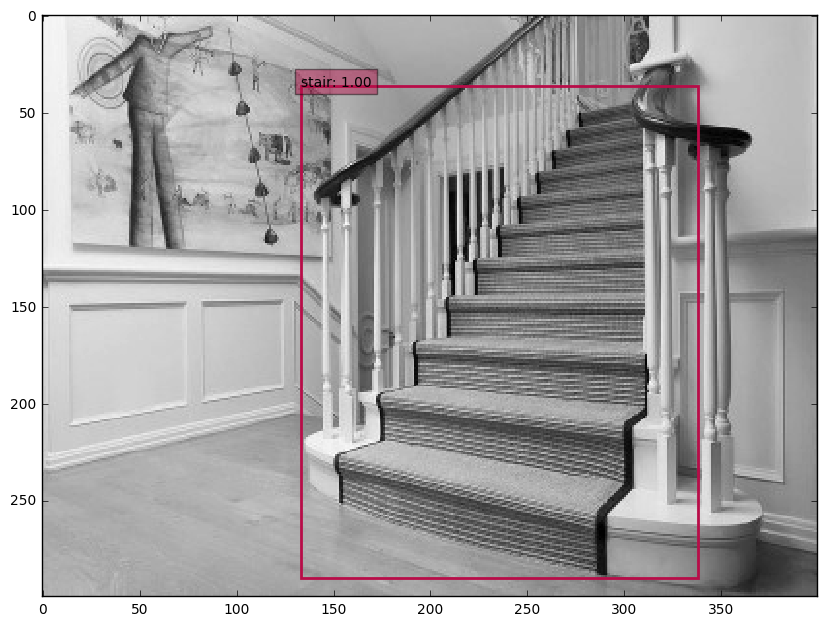

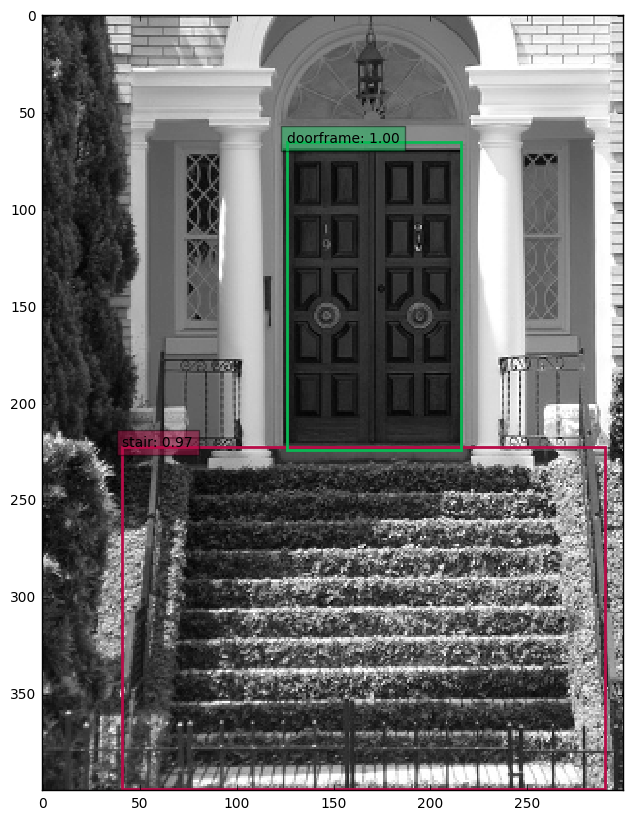

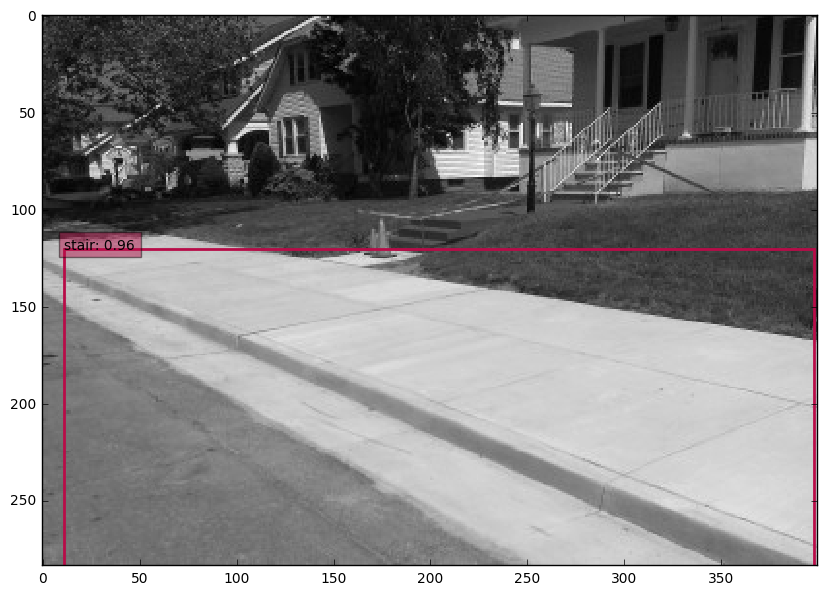

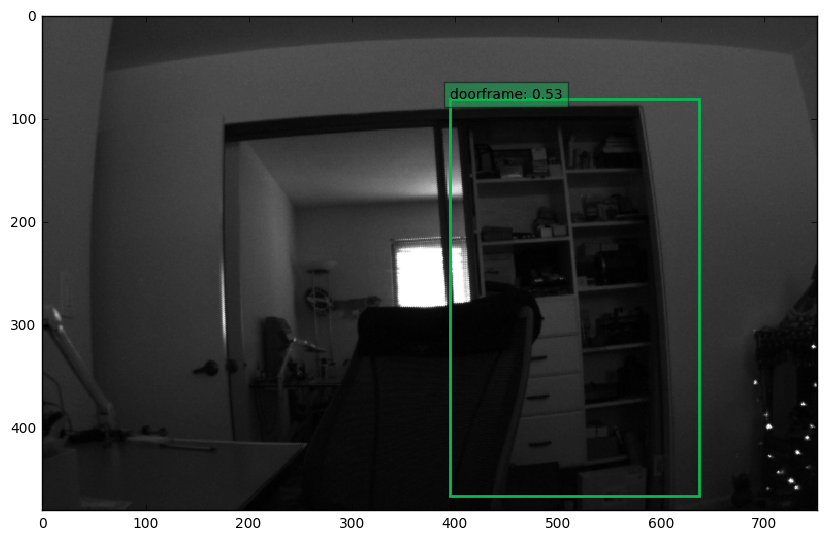

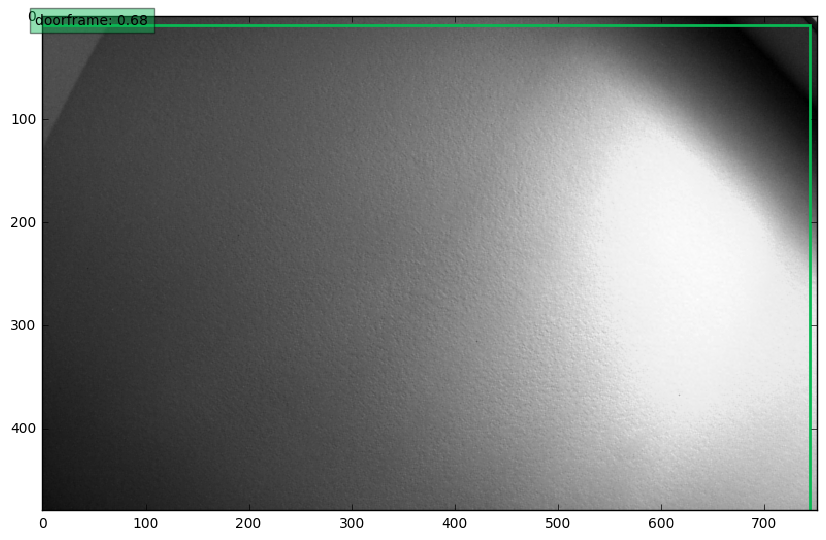

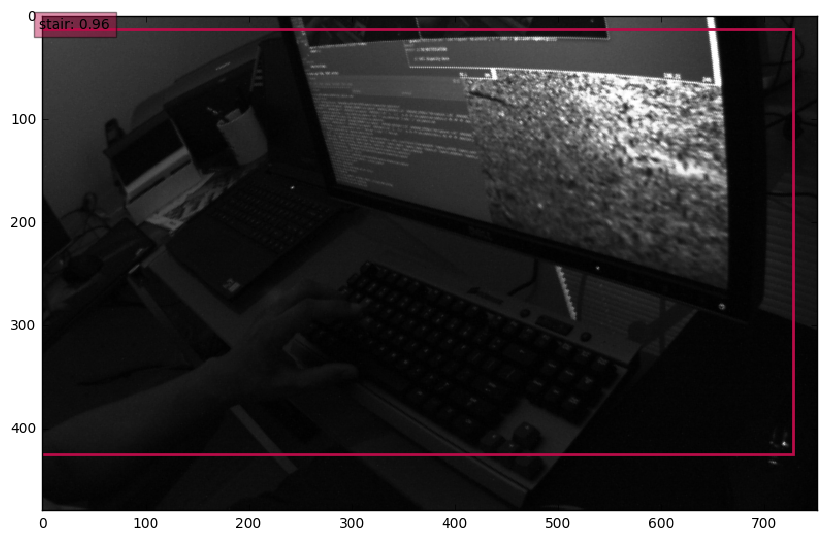

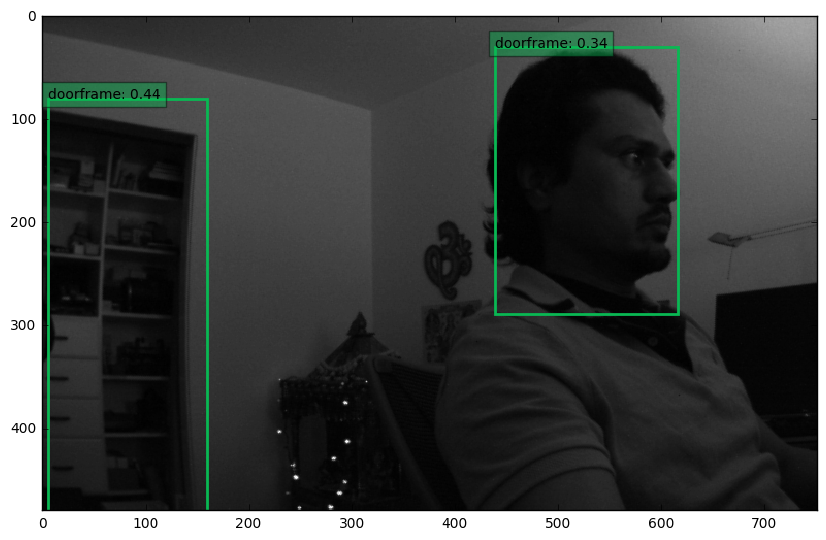

In [4]:
nparams = sum([ (reduce(lambda x,y: x*y, p.data.shape)) for k in net.params for i,p in enumerate(net.params[k]) ])
print "Number of parameters: {}".format(nparams)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
print "Network data layer shape: ", net.blobs['data'].data.shape
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1)) # (h, w, c) to (c, h, w). c=channels, h=height, w=width
transformer.set_mean('data', np.array([104])) #np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
#transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB





##/////////////////////////////////////////////////////////////////////////////////////////////////////////
# set net to batch size of 1
image_resize = imsize
net.blobs['data'].reshape(1,1,image_resize,image_resize) # batch=1,channels=1,height,width (c=1 for grayscale)

if True:
    im_path = "/home/maheriya/Projects/py-faster-rcnn/data/demo/"
    im_names = ['1_stair_001.jpg', '1_stair_002.png', '2_curb_001.jpg', '2_curb_002.jpg',
                #'3_doorframe_001.jpg', '3_doorframe_002.png', 
                #'00120_00_BASE_IMAGE.png', '1_stair_00589_00_BASE_IMAGE.png',
                #'2_curb_00101_00_BASE_IMAGE.png', '2_curb_00570_00_BASE_IMAGE.png', '2_curb_00503_00_BASE_IMAGE.png',
                #'mono_imgl_3.png', 'mono_imgl_4.png', 'mono_imgl_5.png',
                #'stair-with-cat.png', 'stair-with-child.png',
                'aptina_cabinet.png', 'aptina_ceiling.png', 'aptina_door.png',
                'aptina_monitor.png', 'aptina_person.png']
else:
    im_path = "/IMAGESETS/DVIADetDB.full/kitti-data/val/images/"
    # im_path = "/IMAGESETS//DVIADetDB.full/test_images_150x150"
    im_names = [
        '1_stair_00020_00_BASE_IMAGE.png',
        '1_stair_00054_00_BASE_IMAGE.png',
        '1_stair_00099_00_BASE_IMAGE.png',
        '1_stair_00587_00_BASE_IMAGE.png',
        '1_stair_00589_00_BASE_IMAGE.png'
        ]

def show_detections(image, fig=1, DEBUG=True):
    ## Run the net and examine the top_k results
    transformed_image = transformer.preprocess('data', image)
    #print "Transformed image shape: ", transformed_image.shape
    net.blobs['data'].data[...] = transformed_image

    # Forward pass.
    detections = net.forward()['detection_out']

    # Parse the outputs.
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]

    if det_conf[0] == -1:
        print "No detections"
        return
    if DEBUG:
        print "det_conf: {}".format(det_conf)
        print "det_label: {}".format(det_label)
        det_labels = get_labelname(labelmap, [i for i in det_label])
        print "det_labels: {}".format(det_labels)
    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.25]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_labels = get_labelname(labelmap, top_label_indices)
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    if DEBUG:
        print "top_indices: {}".format(top_indices)
        print "top_conf: {}".format(top_conf)
        #print "top_label_indices: {}".format(top_label_indices)
        print "top label: {}".format(top_labels)
    ## Plot the boxes
    ##------------------------------------------------------------------------
    colors = np.array([[0, 0, 0, 0xff], [0xb8, 0x0c, 0x48, 0xff], [0x09, 0xb8, 0x53, 0xff], [0x0c, 0x84, 0xb8, 0xff]])/255.0
    #colors = matplotlib.colors.ListedColormap(rgbarray, name='from_list', N=3)
    #colors = plt.cm.hsv(np.linspace(0, 1, 3)).tolist()
    ##------------------------------------------------------------------------

    plt.figure(fig)
    # For grayscale images, extra array transform is required for imshow
    img = image.reshape((image.shape[0], image.shape[1])) # from (300,300,1) to (300x300)

    plt.imshow(img, cmap='gray') # grayscale image
    currentAxis = plt.gca()

    for i in xrange(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * image.shape[1]))
        ymin = int(round(top_ymin[i] * image.shape[0]))
        xmax = int(round(top_xmax[i] * image.shape[1]))
        ymax = int(round(top_ymax[i] * image.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = top_labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.45})

#

#image = caffe.io.load_image(os.path.join(im_path, im_names[0]))
#from PIL import Image
fig = 1
for img in im_names:
    print "_______________________________________________"
    print "Image {}".format(img)

    #image = np.asarray(Image.open(os.path.join(im_path, img)).convert("L"))
    image = caffe.io.load_image(os.path.join(im_path, img),color=False)
    show_detections(image, fig)
    fig += 1
    print ""
    #break